In [16]:
import Core 
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cvx

In [17]:
%matplotlib nbagg

# User Equilibrium

in this section the user equilibrium solution will be found using projection free method . by this i mean in every iteration  

<IPython.core.display.Javascript object>


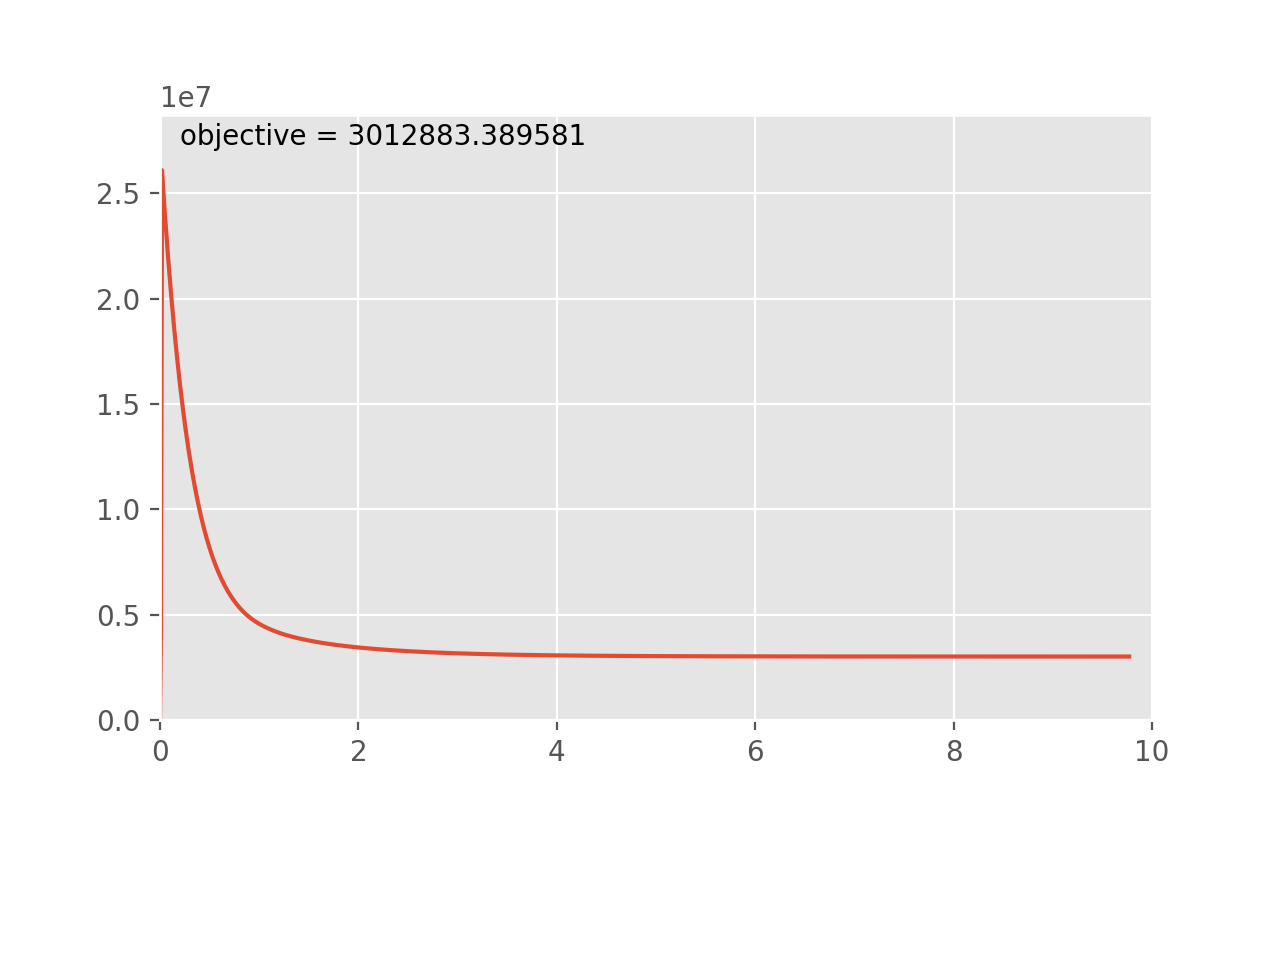

In [18]:
mode = 'only shortest paths'
slowVersion = False
graph = Core.CustomGraph(4,4 ,mode=mode , add_incidence_matrix = False)
uesolver = Core.UESolver(graph, slowVersion = slowVersion )
numberOfNodes, numberOfEdges  = len(graph.nodes), len(graph.edges)
uesolver.solve()

In [19]:
# after closing the figure the UESolver.close will be called !
numberOfPaths = graph.H.shape[1]

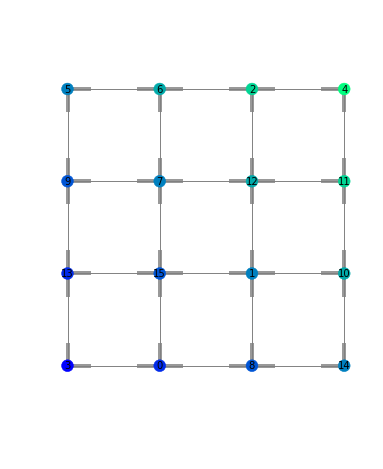

In [20]:
#Last Checkpoint save
uesolver.save_output()
%matplotlib inline
# plot network
plt.figure(figsize=(6,8))
graph.plot()

In [21]:
if slowVersion:
    plt.figure(figsize = (8,4))
    plt.subplot(121)
    xvalues = range(len(uesolver.flow_on_routes))
    plt.bar(xvalues , uesolver.flow_on_routes)
    plt.title('flow on routes bar plot')

    plt.subplot(122)
    plt.hist(uesolver.flow_on_routes,bins = 30) ;
    plt.title('Histogram Of Flows on Paths')

# Check Results

as we can see only a few of routes are now being used so now let's see how many ! and then check the KCL conditions in graph

In [22]:
true_od = graph.Demand.copy()
np.fill_diagonal(true_od , 0)

if mode == 'all simple paths' and slowVersion:
    my_od = uesolver.reshape(graph.H.dot(uesolver.flow_on_routes) , distance_effect=True)
    # Hx = f
    assert np.allclose(my_od.ravel() , true_od.ravel())
    # Ax = y
    assert np.allclose(graph.A.dot(uesolver.flow_on_routes) , graph.y)

# CVX Problem

Let us Assume that $A$ is the link-path incidence matrix and $H$ be the pair-path incidence matrix . so our objective will be as follows :

$$ \min{\: || \square(Hx) + D \:||_* + \lambda ||Ax-y||^2 } \\ s.t \quad x \ge 0  \\ D \text{ is diagonal} , D \ge 0$$

where square symbol means we have to reshape the input vector to a dimentiality appropariate matrix . 

In [23]:
# CVX Problem
Landa = cvx.Parameter(nonneg=True)
Landa.value = 0.1

x = cvx.Variable(numberOfPaths , name="Path Flows")
D = cvx.Variable((numberOfNodes , numberOfNodes) , name="Pertrubation")

constraints = [x >= 0] + [D[i, j] == 0 for i in range(numberOfNodes) for j in range(numberOfNodes) if i is not j] + \
              [D[i,i] >= 0 for i in range(numberOfNodes)]

y_true = graph.y.copy()

#LowRank = cvx.normNuc(Core.reshape(graph.H * x, graph.nodes_dictionary, graph.nodes.keys()) + D)
LowRank = cvx.normNuc(cvx.reshape(graph.H * x, (numberOfNodes , numberOfNodes)) + D)
Noise = cvx.sum_squares(graph.A * x - y_true)
obj = cvx.Minimize(Landa*Noise + LowRank)
problem = cvx.Problem(obj, constraints)
CVXOPT_properties = {'solver':cvx.CVXOPT , 'verbose':True , 'max_iters':200 , 'kkt_solver':"chol",
                     'refinement':1 , 'abstol':1e-7 , 'reltol':1e-6}
SCS_properties = {'solver':cvx.SCS , 'verbose':True , 'max_iters':20000 , 'eps':1e-5 , 'use_indirect':True,
                  'warm_start':True}

In [24]:
print problem.solve(**SCS_properties)
print "Noise Value is %f and LowRank Value is %f" % (Noise.value , LowRank.value)

----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 5566, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 20000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 1528, constraints m = 1834
Cones:	primal zero / dual free vars: 496
	linear vars: 760
	soc vars: 50, soc blks: 1
	sd vars: 528, sd blks: 1
Setup time: 3.19e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 3.77e+20  4.32e+20  1.00e+00 -1.87e+23  7.77e+22  2.20e+22  4.14e-03 
   100| 3.56e-02  5.43e-02  7.16e-04  7.08e+02  7.07e+02  4.09e-14  9.80e-02 
   

# Solution For Different $\lambda$ values

In [25]:
errors = []
problem_values = []
landa_vals = np.logspace(-2,1.2,30)

for lambda_val in landa_vals:
    Landa.value = lambda_val
    print("Optimal Value : {:.3f} , Lambda : {:.4f}".format(problem.solve(solver = cvx.SCS , verbose=False) , Landa.value))
    errors.append((problem.value, LowRank.value, Noise.value * Landa.value))
    problem_values.append((x.value , D.value.diagonal()))

Optimal Value : 671.627 , Lambda : 0.0100
Optimal Value : 676.267 , Lambda : 0.0129
Optimal Value : 680.048 , Lambda : 0.0166
Optimal Value : 683.096 , Lambda : 0.0214
Optimal Value : 685.552 , Lambda : 0.0276
Optimal Value : 687.511 , Lambda : 0.0356
Optimal Value : 689.073 , Lambda : 0.0459
Optimal Value : 690.309 , Lambda : 0.0592
Optimal Value : 691.284 , Lambda : 0.0763
Optimal Value : 692.047 , Lambda : 0.0984
Optimal Value : 692.656 , Lambda : 0.1269
Optimal Value : 693.132 , Lambda : 0.1636
Optimal Value : 693.505 , Lambda : 0.2109
Optimal Value : 693.804 , Lambda : 0.2719
Optimal Value : 694.034 , Lambda : 0.3506
Optimal Value : 694.217 , Lambda : 0.4520
Optimal Value : 694.361 , Lambda : 0.5828
Optimal Value : 694.484 , Lambda : 0.7514
Optimal Value : 694.577 , Lambda : 0.9687
Optimal Value : 694.650 , Lambda : 1.2490
Optimal Value : 694.713 , Lambda : 1.6103
Optimal Value : 694.761 , Lambda : 2.0761
Optimal Value : 694.798 , Lambda : 2.6766
Optimal Value : 694.826 , Lambda :

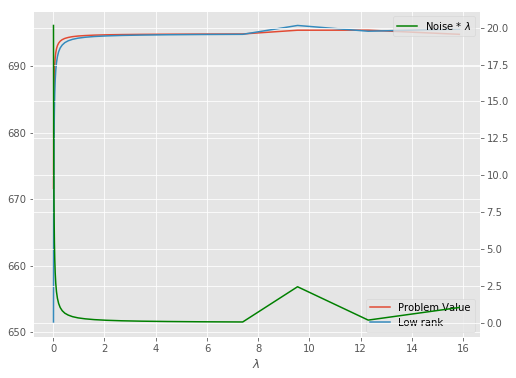

In [26]:
fig , ax = plt.subplots(figsize=(8,6))
error_data = np.array(errors)
ax.plot(landa_vals , error_data[:,:2])
ax.legend(['Problem Value','Low rank'])

ax1 = ax.twinx()

ax1.plot(landa_vals,error_data[:,2],color='g')
ax1.legend(['Noise * $\lambda$'])

ax.set_xlabel('$\lambda$') ;

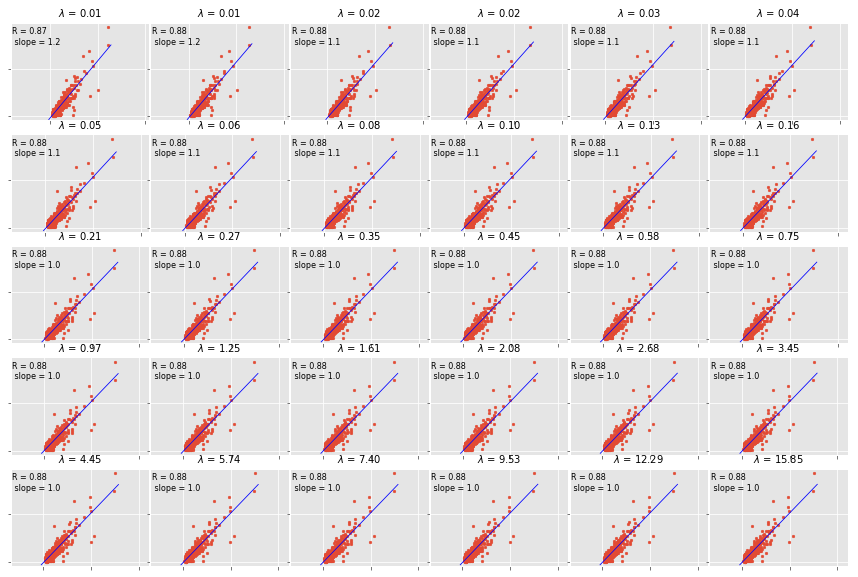

In [27]:
from scipy.stats import linregress

fig , ax = plt.subplots(nrows=int(np.sqrt(len(landa_vals))),ncols=int(np.sqrt(len(landa_vals)))+1, figsize=(15,10),sharey=True)
plt.subplots_adjust(hspace = 0.14 , wspace = 0.01)

for indx , ax1 in enumerate(ax.flatten()):
    ax1.xaxis.set_major_formatter(plt.NullFormatter())
    ax1.yaxis.set_major_formatter(plt.NullFormatter())
    try : my_od = uesolver.reshape(graph.H.dot(np.array(problem_values[indx][0])),distance_effect=True)
    except: continue
    # distance on the diag is 1
    my_od += np.diag(problem_values[indx][1])
    slope, intercept, r_value, p_value, std_err = linregress(my_od.ravel(),graph.Demand.ravel())
    RegressLine = lambda x: intercept + x * slope
    ax1.scatter(my_od.ravel(),graph.Demand.ravel(),s=7)
    
    xlim , ylim = ax1.get_xlim() , ax1.get_ylim()
    xData = np.linspace(xlim[0],xlim[1],200)
    ax1.plot(xData , RegressLine(xData),color='b',linewidth=0.8)
    ax1.text(0.01,0.78,'R = %.2f \n slope = %.1f' % (r_value,slope) ,transform=ax1.transAxes,fontdict={'fontsize':8})
    ax1.axis('equal')
    ax1.set_xlim(xlim) ; ax1.set_ylim(ylim)
    ax1.set_title('$\lambda$ = %.2f' % landa_vals[indx],fontsize=10)

In [15]:
# Low Rank OD Form Real VS. Estimated
low_nuc_od = uesolver.reshape(graph.H.dot(np.array(x.value)) , distance_effect=False)
low_nuc_od[np.diag_indices_from(low_nuc_od)] = D.value.diagonal()
# Rank Of Estimated Matrix
_ , s , _ = np.linalg.svd(low_nuc_od)
s

array([3.62823968e+02, 2.76284297e+00, 2.48581698e-04, 2.26039950e-04,
       1.05512967e-04, 8.93684065e-05, 7.17326798e-05, 2.88431283e-05,
       8.05410281e-06])

In [26]:
numberOfNodes, numberOfPaths, numberOfEdges

(12, 217, 34)

as we can see most of the time the solution is low rank or rank-1 but the thing is our objective has a regularization in it's nature , so the value estimated might have been underesteemated . but the thing is how well did we estimate those Unitary matrices ! 